In [ ]:
import pandas as pd
import scipy.io
import mpld3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pymatreader
from sklearn import preprocessing as p

mpld3.enable_notebook()

In [ ]:
x = [1,2,3,4]

print(p.normalize(x))

In [ ]:
def preprocessing(x):
    
    def get_condition(x):
        x_mean = np.mean(x)
        x_min = np.min(x)
        return np.mean([x_min, x_min])
    
    def find_first_seq(x):
        pos = 0
        condition = get_condition(x)
        for i in range(len(x)-1):
            if abs(x[i] - x[i+1]) >= np.mean(x[:i]):
                break
            else: 
                pos += 1
        return np.mean(x[:pos]), pos
    
    def preprocess(x):
        dev, c = find_first_seq(x)
        for i in range(len(x)):
            x[i] -= dev
        return x
    
    def remove_negative_values(x):
        for i in range(len(x)):
            if x[i] < 0:
                x[i] = 0
        return x
    
    def filter_first_seq(x):
        ""
    
    return remove_negative_values(preprocess(x))


def interpolate(x):
    y = np.cos(-x**2/9.0)
    return scipy.interpolate.interp1d(x, range(len(x)), kind='cubic')

In [ ]:
def load_file(name) -> dict:
    data_path = os.getcwd() + '\data'
    data_f = {}
    data = pymatreader.read_mat(data_path + "\\" + name)
    signal = data['tissue'][0]
    T_s = data['info']['acq']["Ts"]
    return {'signal' : data['tissue'][0], 'time' : np.linspace(0, 0+(T_s*len(signal)),len(signal),endpoint=False), 'ts' : T_s}

In [ ]:
def load_data() -> dict:
    data_path = os.getcwd() + '\data'
    data = {}
    for file in os.listdir(data_path):
        if ".mat" in file:
            data[file.replace('.mat','')] = load_file(file)
    return data

In [ ]:
data = load_data()

In [ ]:
print(load_data()['info']['acq']["Ts"])
print(load_data()['info']['tissue'])
print(load_data()['tissue'][0])

In [ ]:
def visualize_all():
    data = load_data()
    for k, v in data.items():
        if k == "exp17_roivelke_inp_tis_111007":
            v = v - np.mean(v[:25])
            p = sns.lineplot(x=range(len(v)), y=v)
            plt.figure()
            plt.grid(False) 
            plt.title(k) 
            plt.xlabel("time")
            plt.ylabel("intesity")
        else: 
            v = preprocessing(v)
            #p = sns.lineplot(x=range(len(v)), y=v)
            p = plt.scatter(x=range(len(v)),y=v)
            plt.figure()
            plt.grid(False) 
            plt.title(k) 
            plt.xlabel("time")
            plt.ylabel("intesity")       

In [ ]:
data = load_data()

In [ ]:
data = data['exp13_aifnova_inp_tis_111017']['signal']

In [ ]:
def remove_negative_values(x):
    max_s = max(x)/10
    for i in range(len(x)):
        if x[i] < 0 or x[i] < max_s:
            x[i] = 0.1
    return x

def pos_min_max(x):
    x = x.tolist()
    max_ind = x.index(np.max(x))
    min_ind = x.index(np.min(x)) 
    if min_ind < max_ind:
        return min_ind, max_ind
    
def ma(x):
    max_ = np.argmax(x)
    min_ = np.argmin(x)
    arr = np.where(x==min_)
    #min_ = arr[0][len(arr[0])-1]
    x = x.tolist()
    max_ind = x.index(np.max(x))
    min_ind = x.index(np.min(x))
    return x[min_:max_], max_ind, min_ind

In [ ]:
import paramnormal

data = load_data()
x = preprocessing(data['exp13_aifnova_inp_tis_111017'])

x_n = x[:20]

b = scipy.signal.resample(x_n, len(x_n) * 2)
s = remove_negative_values(np.append(b,x_n[20:]))

print(s)
signal, max, min = ma(s)
#print(min)

s_2 = []
signal, max, min = ma(s)
s2 = scipy.signal.resample(s[min:max], len(s[min:max]) * 2)
[s_2.append(i) for i in [s[:min], s_2, s[max:]]]

b_2 = scipy.signal.resample(s, len(s) * 2)
x = np.linspace(np.min(s_2),np.max(s_2))

params = paramnormal.lognormal.fit(s)
dist = paramnormal.lognormal.from_params(params)
plt.figure()
plt.plot(x, dist.pdf(x), color='black')
plt.scatter(x, dist.pdf(x), color='blue', marker="*")
plt.xlabel('time [s]')
plt.ylabel('Backscatter intensity')
plt.title('Log Normal Model')
plt.show()

In [93]:
from dipl.functions.lagnorm import LAGG
from dipl.functions.lognorm import LOGNORM
from dipl.functions.fpt import FPT
from dipl.functions.gamma import GAMMA
from dipl.functions.ldrw import LDRW
import pymatreader
import os
import numpy as np
import matplotlib.pyplot as plt


class ModuleModelData2:
    """
    Class for loading and preprocessing the data.
    Also displays the data.
    Directory: data/dataset_2
    """
    def __init__(self):
        self.load_data()

    def load_data(self):
        data_path = os.getcwd() + '\data\dataset_2'
        for file in os.listdir(data_path):
            if ".mat" in file:
                load_file(file)

    def load_file(self, name):
        data_path = os.getcwd() + '\data\dataset_2'
        data = pymatreader.read_mat(data_path + "\\" + name)
        signal = []
        dataset = data['data1']

        for i in range(0, len(dataset)):
            x = np.floor(dataset[i].shape[1] / 2)
            y = np.floor(dataset[i].shape[0] / 2)
            signal.append(dataset[i][int(y)][int(x)])

        x = signal
        time = data['info']["acq"]['TimeStamps']
        ts = data['info']['acq']["Ts"]

        ldrw = LDRW(x, time)
        fit_ldrw = ldrw.fit

        gamma = GAMMA(x, time)
        fit_gamma = gamma.fit

        fpt = FPT(x, time)
        fit_fpt = fpt.fit

        lognorm = LOGNORM(x, time, ts)
        fit_lognormal = lognorm.fit

        lagged = LAGG(x, time)
        fit_lagged = lagged.fit

        plt.figure()
        plt.plot(time, x, 'o', label='data')
        plt.plot(time, fit_lognormal, '-', label='lognormal')
        plt.plot(time, fit_gamma, '-', label='gamma variate')
        plt.plot(time, fit_ldrw, '-', label='ldrw')
        plt.plot(time, fit_fpt, '-', label='fpt')
        plt.plot(time, fit_lagged, '-', label='lagged normal')
        plt.title(name)
        plt.legend(loc='upper right')
        plt.ylabel('Intensity')
        plt.xlabel('Time [s]')
        plt.show()

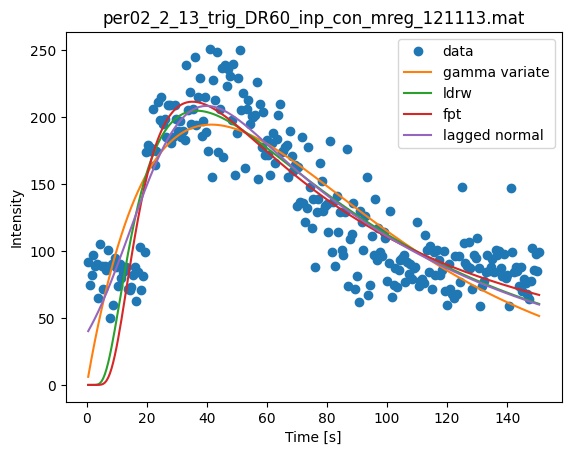

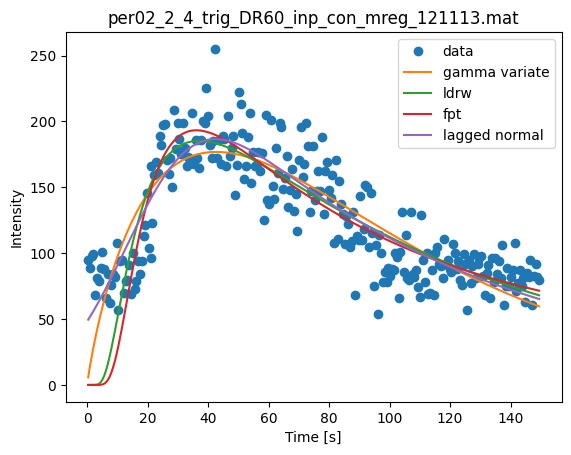

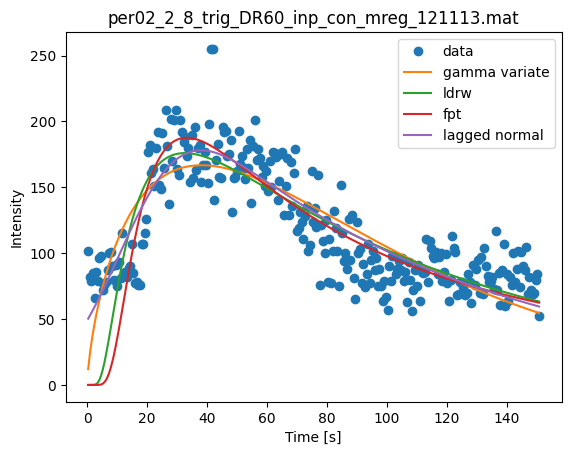

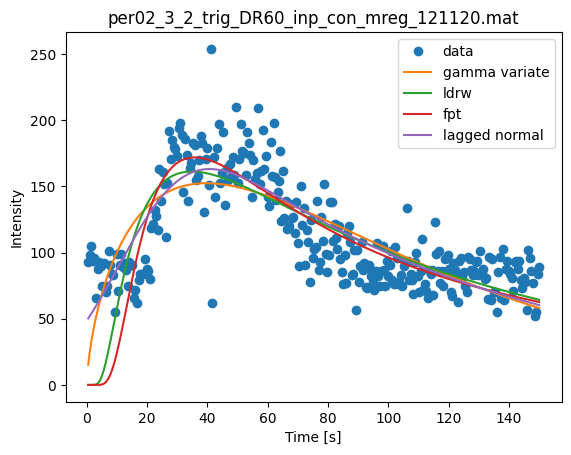

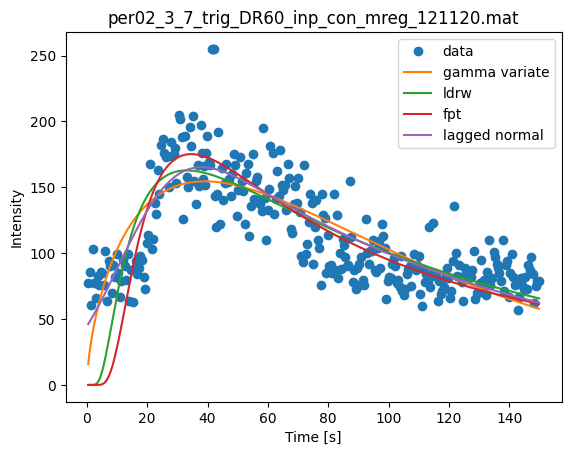

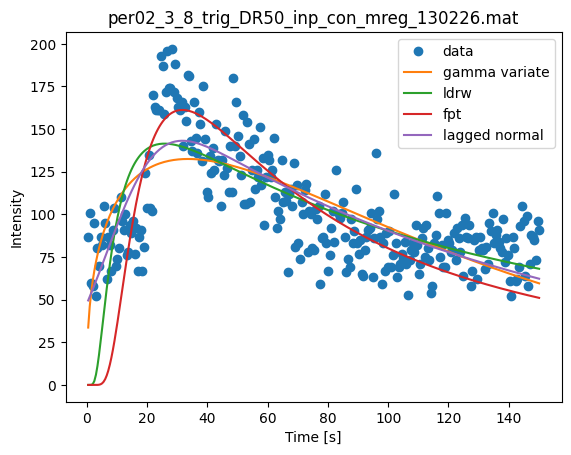

In [94]:
ModuleModelData2()

In [21]:
import numpy as np
import os
import math
from pyswarm import pso
import pymatreader

def load_file_n(name):
    data_path = os.getcwd() + '\data\dataset_2'
    data = pymatreader.read_mat(data_path + "\\" + name)
    signal = []
    dataset = data['data1']

    for i in range(0, len(dataset)):
        x = np.floor(dataset[i].shape[1] / 2)
        y = np.floor(dataset[i].shape[0] / 2)
        signal.append(dataset[i][int(y)][int(x)])

    x = signal
    time = data['info']["acq"]['TimeStamps']
    ts = data['info']['acq']["Ts"]
    return x, time, ts

# define the objective function
def objective_function(params, signal):
    auc, alpha, beta = params
    output = [(auc * (x ** alpha) * np.exp(-1 * x / beta)) / (beta ** (alpha + 1) * math.gamma(alpha + 1)) for x in signal]
    return np.sum(np.abs(output))


# define the search space boundaries
param_ranges = [(0.1, 1), (0.1, 10), (0.1, 10)]

# define the signal data
# signal = np.random.rand(100)
signal, time, ts = load_file_n("per02_2_4_trig_DR60_inp_con_mreg_121113.mat")

# run the cuckoo search algorithm
best_params = pso(objective_function, lb=[p[0] for p in param_ranges], ub=[p[1] for p in param_ranges], args=[signal], maxiter=1000,swarmsize=20)

# print the best parameter values
print("Best parameters:", best_params)

Stopping search: Swarm best objective change less than 1e-08
Best parameters: (array([0.37295532, 2.03014016, 0.1       ]), 1.9346050288431457e-229)


In [5]:
import numpy as np
from mealpy.swarm_based.ACOR import OriginalACOR

def ldrw_model( auc, lamd, mu):
    return auc * (np.exp(lamd) / lamd) * np.sqrt((mu * lamd) / (x * 2 * np.pi)) * np.exp(
        -0.5 * lamd * ((mu / x) + (x / mu)))

def fitness_function(solution):
    auc, lamd, mu = solution
    predictions = ldrw_model(auc, lamd, mu)
    return np.sum((predictions - target)**2)

target = [1, 2, 3, 4, 5] # example target values

problem_dict1 = {
    "fit_func": fitness_function,
    "lb": [[1]*5, 1, 1, 1], # lower bounds for signal, auc, lamd, mu
    "ub": [[10]*5, 10, 10, 10], # upper bounds for signal, auc, lamd, mu
    "minmax": "min",
}

epoch = 1000
pop_size = 50
sample_count = 25
intent_factor = 0.5
zeta = 1.0
model = OriginalACOR(epoch, pop_size, sample_count, intent_factor, zeta)
best_position, best_fitness = model.solve(problem_dict1)
print(f"Solution: {best_position}, Fitness: {best_fitness}")


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'